<a href="https://colab.research.google.com/github/ulkuhos/YSA_Dersi_2024/blob/main/Ulku_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **1.Gerekli Kütüphanelerin Yüklenmesi:**

In [8]:
# Veri işleme
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import os
import kagglehub
import keras
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt


# Model oluşturma ve değerlendirme
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix


# TensorFlow ve Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

Colab ile drive bağlatısını sağlama:

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


KaggleHub'ı yükleme:

In [9]:
!pip install kagglehub  # Eğer kurulu değilse, KaggleHub'ı yükle

### **2.	Veri Seti Yükleme**

Veri setini Kaggle linkinden yükleme:

In [10]:
# Veri setini indirme:
path = kagglehub.dataset_download("omkargurav/face-mask-dataset")

print("Veri seti indirildi, dosya yolu:", path)

100%|██████████| 163M/163M [00:00<00:00, 197MB/s]

Extracting files...


Veri seti indirildi, dosya yolu: /root/.cache/kagglehub/datasets/omkargurav/face-mask-dataset/versions/1


Veri setini drive üzerinde yeni konumuna yükleme:

In [12]:
#Veri setini drive üzerinde yeni konumuna yükleme: Eğer konum bulamıyorsa yapılır:

import shutil

# Google Drive içindeki kaydetmek istediğin dizini belirleme:
destination_path = "/content/drive/My Drive/face-mask-dataset-new"

# Kopyalama işlemini gerçekleştirme:
shutil.copytree(path, destination_path)

print(f"Veri seti başarıyla Google Drive'a kopyalandı: {destination_path}")


Veri seti başarıyla Google Drive'a kopyalandı: /content/drive/My Drive/face-mask-dataset-new


Veri setinin içinde hangi dosyalar olduğunu öğrenme:

In [13]:
# Kopyalanan veri setinin içeriğini listele
destination_path = "/content/drive/My Drive/face-mask-dataset-new"  # Kopyaladığın klasörün yolu
print(os.listdir(destination_path))


['data']


Maskeli ve maskesiz görüntülerin olduğu klasörleri doğrulama:

In [14]:
# Veri setinin Drive'daki yolu
dataset_path = "/content/drive/My Drive/face-mask-dataset-new/data"

# Maskeli ve maskesiz görüntülerin klasörlerini listele
with_mask_path = os.path.join(dataset_path, "with_mask")
without_mask_path = os.path.join(dataset_path, "without_mask")

print("With mask klasörü:", os.listdir(with_mask_path)[:5])  # İlk 5 maskeli görüntü
print("Without mask klasörü:", os.listdir(without_mask_path)[:5])  # İlk 5 maskesiz görüntü


With mask klasörü: ['with_mask_1959.jpg', 'with_mask_1856.jpg', 'with_mask_2349.jpg', 'with_mask_1527.jpg', 'with_mask_2289.jpg']
Without mask klasörü: ['without_mask_1257.jpg', 'without_mask_3106.jpg', 'without_mask_3617.jpg', 'without_mask_1705.jpg', 'without_mask_494.jpg']


OpenCV ve Matplotlib kullanarak 2 satır ve 5 sütun olmak üzere  5 maskeli ve 5 maskesiz görseli yan yana ekrana yazdırma:

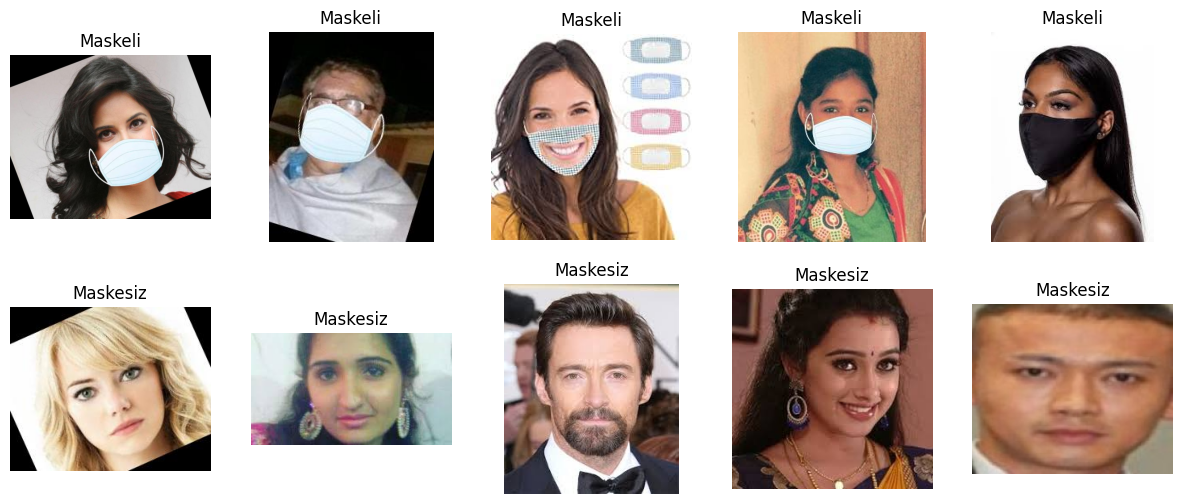

In [15]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2 satır, 5 sütunluk bir tablo oluştur

# İlk 5 maskeli görseli çiz
for i, img_name in enumerate(os.listdir(with_mask_path)[:5]):
    img_path = os.path.join(with_mask_path, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    axes[0, i].imshow(img)
    axes[0, i].set_title("Maskeli")
    axes[0, i].axis("off")

# İlk 5 maskesiz görseli çiz
for i, img_name in enumerate(os.listdir(without_mask_path)[:5]):
    img_path = os.path.join(without_mask_path, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    axes[1, i].imshow(img)
    axes[1, i].set_title("Maskesiz")
    axes[1, i].axis("off")

plt.show()


### **3.	Önceden Eğitilmiş (Pre-trained) Modellerin Hazırlanması**

Sınıflandırıcı olarak DenseNet121 ve MobileNetV1 (pre-trained) modellerinden en az biri kullanılacaktır. Base modeller indirildikten sonra 2 dense katmanı ve bir dropout katmanı ekleyiniz.


**Modeli Hazırlama (MobileNetV1 ile)**

MobileNetV1 modelimizi hazırlayıp optimize etme işlemi:


In [16]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# MobileNet modelini yüklema işlemi:
base_model = MobileNet(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Modelin katmanlarını dondurma adımı: (transfer learning)
for layer in base_model.layers:
    layer.trainable = False

# Yeni katmanları ekleme:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = Dense(128, activation="relu")(x)
predictions = Dense(2, activation="softmax")(x)  # 2 sınıf (maskeli/maskesiz)

# Yeni modeli oluşturma:
model = Model(inputs=base_model.input, outputs=predictions)

# Modeli derleme:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Model özetini gösterme:
model.summary()


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,524,418 (13.44 MB)

 Trainable params: 295,554 (1.13 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

**Yapılan işlemler:**

-MobileNetV1 modelini eklendi.

-Pre-trained MobileNetV1 modeli yüklendi.

-2 Dense katmanı + 1 Dropout katmanı eklendi.

-Softmax çıkışı ile maskeli/maskesiz sınıflandırma yapıldı.


### **4.	Veri Setinin Eğitim/Validasyon ve Test Olarak Ayrılması:**

Toplam verinin %20’si test set olarak ayrılmalı, %80’i eğitim/validasyon için bırakılmalıdır.

In [19]:
from sklearn.model_selection import train_test_split

dataset_path = "/content/drive/My Drive/face-mask-dataset-new/data"

# Maskeli ve maskesiz klasörlerin yolunu al
with_mask_path = os.path.join(dataset_path, "with_mask")
without_mask_path = os.path.join(dataset_path, "without_mask")

# Görselleri listele
with_mask_images = [os.path.join(with_mask_path, img) for img in os.listdir(with_mask_path)]
without_mask_images = [os.path.join(without_mask_path, img) for img in os.listdir(without_mask_path)]

# Tüm görselleri birleştir
all_images = with_mask_images + without_mask_images

# Eğitim ve test için bölme işlemi (%80 eğitim, %20 test)
train_data, test_data = train_test_split(all_images, test_size=0.20, random_state=42)

# Eğitim verisini tekrar bölerek %80 eğitim, %20 validasyon ayıralım
train_data, val_data = train_test_split(train_data, test_size=0.20, random_state=42)

# Kaç görsel olduğunu gösterelim
print(f"Toplam Eğitim Görüntüleri: {len(train_data)}")
print(f"Toplam Validasyon Görüntüleri: {len(val_data)}")
print(f"Toplam Test Görüntüleri: {len(test_data)}")


Toplam Eğitim Görüntüleri: 4833
Toplam Validasyon Görüntüleri: 1209
Toplam Test Görüntüleri: 1511


**Yapılan işlemler:**

-Önce alt klasörleri listeleyip, içindeki görsellerin yolunu aldık.

-Ardından tüm görselleri tek bir listeye topladık.

-Toplam verinin %20’si test seti olarak ayrıldı.

-Eğitim/validasyon seti %80 olarak bırakıldı.

-Eğitim verisini tekrar %80’i eğitim, %20’si validasyon seti olarak ayırdık.

-Kaç görsel olduğunu print() ile gösterdik.

### **5.	Eğitim/Validasyon Setinin Bölünmesi ve Modelin Eğitilmesi**

o	Daha önce ayırdığınız eğitim+validasyon verisini %80’i eğitim %20’si validasyon olarak rastgele bölün.
Eğitim verisine  veri arttırımı uygulayın.

o	Modellerinizi 100 epok boyunca eğitin.

o	Early Stopping kullanın: patience=25 olarak ayarlayın. 25 epok boyunca validasyon kaybında (validation loss) iyileşme olmazsa eğitim duracaktır.

o	Optimizer olarak ADAM (Adaptive Moment Estimation) veya  SGD (Stochastic Gradient Descent) kullanın.

o	Öğrenme hızı lr başlangıç değerini 0.001 olarak başlatın.

o	Momentum değeri isteğe bağlı ayarlanabilir (örn. 0.9).

o	ReduceLROnPlateau mekanizması ile validasyon kaybı iyileşme göstermediğinde öğrenme hızını (lr) otomatik olarak azaltın. Örneğin: factor=0.1, patience=5 vs.

o	Eğitim/Validasyon Accuracy ve Loss Grafiklerini rapora ekleyin.

o	Her epok sonunda eğitim kaybı (loss) ve doğruluğu (accuracy) ile validasyon kaybı ve doğruluğunu kaydedin ve eğriyi çizdirin.


**Veri Artırımı (Data Augmentation)**

-Veri artırımı sadece eğitim setine uygulanıyor.

-Validasyon ve test setleri için sadece yeniden ölçekleme (rescale=1./255) uygulanıyor.

-flow_from_directory yerine flow_from_dataframe kullanıldı. (Çünkü artık eğitim/test setlerini manuel olarak ayırdık.)

-Test seti shuffle=False olarak ayarlandı (Tahmin aşamasında görsellerin sırası değişmemesi için.)

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Eğitim verisi için Data Augmentation (Veri Artırımı)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  # 10 dereceye kadar döndürme
    width_shift_range=0.1,  # Genişlik kaydırma (%10)
    height_shift_range=0.1,  # Yükseklik kaydırma (%10)
    shear_range=0.1,  # Kesme dönüşümü (%10)
    zoom_range=0.1,  # Zoom (%10)
    horizontal_flip=True,  # Yatay çevirme
    fill_mode="nearest"
)

# Validasyon ve Test seti için sadece normalizasyon uygulama:
val_test_datagen = ImageDataGenerator(rescale=1./255)

# DataFrame oluşturma ve etiketleri belirleme:
def create_dataframe(file_list):
    df = pd.DataFrame({"filename": file_list})
    df["label"] = df["filename"].apply(lambda x: "with_mask" if "with_mask" in x else "without_mask")
    return df

train_df = create_dataframe(train_data)
val_df = create_dataframe(val_data)
test_df = create_dataframe(test_data)

# Eğitim setini oluşturma:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filename",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary"  # **Sadece 2 sınıf olduğu için binary**
)

# Validasyon setini oluşturma:
val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="filename",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary"
)

# Test setini oluşturma
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filename",
    y_col="label",
    target_size=(224, 224),
    batch_size=1,
    class_mode="binary",
    shuffle=False
)



Found 4833 validated image filenames belonging to 2 classes.
Found 1209 validated image filenames belonging to 2 classes.
Found 1511 validated image filenames belonging to 2 classes.


-Sadece 2 sınıfımız (Maskeli, Maskesiz) olduğu için çıkış nöronunu 1 yapacağız.

-Softmax yerine Sigmoid kullanıyoruz (binary classification için uygun olan aktivasyon fonksiyonu).
(Sigmoid + Adam: Daha hızlı, daha optimize, ikili sınıflandırma için en iyi seçenek.)

-Kayıp fonksiyonunu (loss) binary sınıflandırmaya uygun hale getiriyoruz.



In [21]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Çıkış katmanı (Sigmoid, 1 nöron) belirliyoruz:
predictions = Dense(1, activation="sigmoid")(x)

# Modeli oluşturuyoruz:
model = Model(inputs=base_model.input, outputs=predictions)

# Optimizer olarak Adam kullanıyoruz:
optimizer = Adam(learning_rate=0.001)

# Modeli derleme (Binary sınıflandırma için uygun hale getirme):
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

# Modelin özetini yazdırma:
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,524,289 (13.44 MB)

 Trainable params: 295,425 (1.13 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

**Model Eğitimi**

***Yapılması Beklenenler:***

-Model 100 epoch boyunca eğitim yapılacak.

-Early Stopping ve ReduceLROnPlateau kullanılacak.

-Optimizer: Adam veya SGD seçilecek.

***Yapılanlar:***

-Train ve Validation generatorları artık flow_from_dataframe ile oluşturulmuş versiyona uyumlu hale getirildi.

-steps_per_epoch=len(train_generator) ve validation_steps=len(val_generator) eklendi. (Bu, her epoch'ta kaç adım olacağını belirliyor ve eğitim sürecini optimize ediyor.)

-Optimizer seçeneği korunarak, adam veya sgd seçme imkanı sağlaıyor.

-Early Stopping ve ReduceLROnPlateau mekanizmaları eğitim sürecini kontrol ediyor.

-Veri artırma (Data Augmentation) kullanan eğitim verisiyle çalışıyor.

-Early Stopping (erken durdurma) eklendi.

-ReduceLROnPlateau ile öğrenme hızını düşürüyoruz.

In [22]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Erken durdurma ve öğrenme oranı azaltmai şlemleri:
early_stopping = EarlyStopping(monitor="val_loss", patience=25, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-6)

# Modeli eğitme:
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=[early_stopping, reduce_lr]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 121s 530ms/step - accuracy: 0.9128 - loss: 0.1784 - val_accuracy: 0.9892 - val_loss: 0.0350 - learning_rate: 0.0010
Epoch 2/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 68s 445ms/step - accuracy: 0.9823 - loss: 0.0564 - val_accuracy: 0.9926 - val_loss: 0.0243 - learning_rate: 0.0010
Epoch 3/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 67s 441ms/step - accuracy: 0.9833 - loss: 0.0469 - val_accuracy: 0.9917 - val_loss: 0.0239 - learning_rate: 0.0010
Epoch 4/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 67s 440ms/step - accuracy: 0.9846 - loss: 0.0409 - val_accuracy: 0.9959 - val_loss: 0.0204 - learning_rate: 0.0010
Epoch 5/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 66s 432ms/step - accuracy: 0.9874 - loss: 0.0361 - val_accuracy: 0.9917 - val_loss: 0.0294 - learning_rate: 0.0010
Epoch 6/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 66s 432ms/step - accuracy: 0.9885 - loss: 0.0376 - val_accuracy: 0.9917 - val_loss: 0.0296 - learning_rate: 0.0010
Epoch 7/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 66s 434ms/step - accur

**Model Eğitim Performansı:**

İlk epoch'ta model doğruluğu: %91.28

5.epoch'ta doğruluk: %98.74, kayıp değeri 0.0361

10.epoch'ta doğruluk: %98.99, kayıp değeri 0.0285

20.epoch'ta doğruluk: %99.59, kayıp değeri 0.0143

Son epoch'ta (39) eğitim doğruluğu: %99.63, validasyon doğruluğu: %99.59
Son kayıp değeri: 0.0182

**Özetle:**

-Model, hızlı bir şekilde yüksek doğruluğa ulaştı ve overfitting yaşanmadı.

-Validasyon doğruluğu da %99.59 ile stabil hale geldi, bu modelin genelleme gücünün yüksek olduğunu gösteriyor.

-Öğrenme oranı 14. epoch'tan sonra azaltılarak modelin daha hassas öğrenmesi sağlandı.

-Eğitim ve validasyon kayıpları düşük seviyede sabitlenerek modelin stabil bir şekilde eğitildiği görüyoruz.

**Sonuç olarak**, model yüksek başarı oranına sahiptir ve gerçek dünya verileri üzerinde güvenilir tahminler yapabilir demek oluyor.

Tekrar kullanabilmemiz için eğittiğimiz modeli kaydettik:

In [24]:
# Eğitilen modeli kaydet
model.save("face_mask_detection_model.keras")
print("Model başarıyla kaydedildi!")



Model başarıyla kaydedildi!


**Bu kod ile, test setindeki doğruluk oranını gösterelim.**

***Modelin Test Setindeki Doğruluğu: %99.60 ***


In [26]:
# Test seti üzerinde modeli değerlendir
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\n Modelin Test Setindeki Doğruluğu: %{test_accuracy * 100:.2f}")


1511/1511 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9979 - loss: 0.0060

 Modelin Test Setindeki Doğruluğu: %99.60


In [58]:
data_path = "/content/drive/My Drive/face-mask-dataset-new/data"
print("Data klasöründeki içerikler:", os.listdir(data_path))


Data klasöründeki içerikler: ['without_mask', 'with_mask']


**Confusion Matrix (Karışıklık Matrisi)**

Bu grafik, modelin test sonuçları üzerinde kaç tane doğru ve yanlış tahmin yaptığını bize gösteriyor.

1511/1511 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step


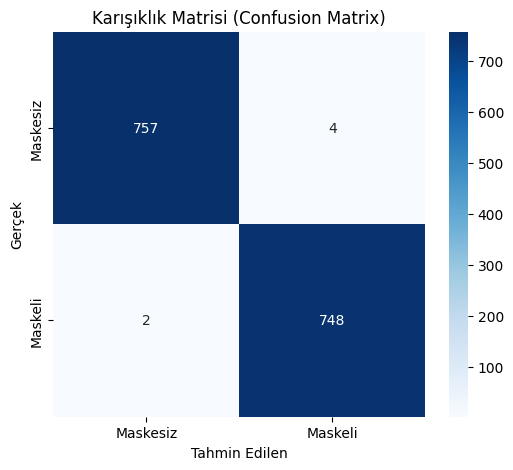


=== Sınıflandırma Raporu ===

              precision    recall  f1-score   support

    Maskesiz       1.00      0.99      1.00       761
     Maskeli       0.99      1.00      1.00       750

    accuracy                           1.00      1511
   macro avg       1.00      1.00      1.00      1511
weighted avg       1.00      1.00      1.00      1511



In [27]:
from sklearn.metrics import confusion_matrix, classification_report

# Modelin tahminlerini alalım:
predictions = model.predict(test_generator)
y_pred = np.round(predictions).astype(int)  # Sigmoid olduğu için yuvarlıyoruz (0 veya 1 yapıyoruz)
y_true = test_generator.classes  # Gerçek etiketleri al

# Confusion Matrix oluşturma:
conf_matrix = confusion_matrix(y_true, y_pred)

# Confusion Matrix görselleştirme:
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Maskesiz", "Maskeli"], yticklabels=["Maskesiz", "Maskeli"])
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.title("Karışıklık Matrisi (Confusion Matrix)")
plt.show()

# Detaylı sınıflandırma raporu:
print("\n=== Sınıflandırma Raporu ===\n")
print(classification_report(y_true, y_pred, target_names=["Maskesiz", "Maskeli"]))


**Tablo Açıklaması:**

Confusion Matrix, modelin maskeli ve maskesiz yüzleri ne kadar doğru sınıflandırdığını gösterir. Matrisin köşegenindeki değerler doğru tahminleri, diğer hücreler ise yanlış tahminleri ifade eder.

**Sonuçlara bakarsak:**

Model toplam 1511 test görüntüsünü sınıflandırdı.

Maskesiz yüzlerin 757’sini doğru tahmin etti, 4 tanesini yanlış maskeli olarak sınıflandırdı.

Maskeli yüzlerin 748’ini doğru tahmin etti, 2 tanesini yanlış maskesiz olarak sınıflandırdı.

Genel doğruluk oranı %99.79 olarak hesaplandı.

F1-score değeri 1.00 olup, modelin tüm sınıfları oldukça iyi ayırabildiğini göstermektedir.

**Değerlendirme:**

Yanlış sınıflandırmalar çok az ve modelin oldukça yüksek bir başarıya sahip olduğunu görüyoruz.

Ancak, gerçek dünya koşullarında test edilmediği için overfitting ihtimali göz önünde bulundurulmalıyız. Aşağıda onun da testini yapacağız.

Genellikle gerçek hayatta modelin performansını ölçmek için farklı aydınlatma, açılar ve veri çeşitliliği ile test edilmesi önerilir.

**ROC Eğrisi (Receiver Operating Characteristic Curve) ve AUC (Area Under Curve)**

Bu grafik bize, modelin sınıflandırma performansını daha detaylı olarak gösterir.

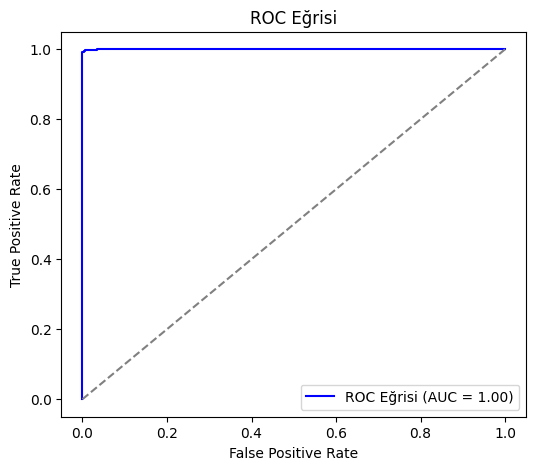

In [29]:
from sklearn.metrics import roc_curve, auc

# Gerçek etiketleri al
y_prob = predictions  # Modelin verdiği olasılıklar

# ROC Eğrisi hesapla
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

# ROC Eğrisi çizdir
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="blue", label=f"ROC Eğrisi (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Eğrisi")
plt.legend(loc="lower right")
plt.show()


**Grafik Yorumları:**

ROC (Receiver Operating Characteristic) Eğrisi, modelin True Positive Rate (Gerçek Pozitif Oranı) ile False Positive Rate (Yanlış Pozitif Oranı) arasındaki ilişkiyi gösterir.
Eğrinin üst köşeye ne kadar yakın olduğu, modelin ne kadar iyi çalıştığını gösterir.

**Sonuç Analizi:**

AUC (Area Under Curve) değeri 1.00 olarak hesaplanmıştır.

Bu, modelin sınıfları mükemmel şekilde ayırdığını göstermektedir.

Eğri, ideal bir sınıflandırıcı gibi neredeyse kusursuz bir şekilde sol üst köşeye yaklaşmıştır.

**Değerlendirme**:

AUC = 1.00 olması, modelin aşırı öğrenme (overfitting) yapmış olabileceğini bize üşündürmektedir.

Gerçek dünyada hiç hata yapmayan bir model olması beklenmez, bu yüzden modelin farklı veri setleriyle test edilmesi gerekir.

Yeni veri ile test yapılarak modelin genelleme yeteneği doğrulanması önemlidir.

**Eğitim/Validasyon Accuracy ve Loss Grafikleri**

Bu grafiklerle modelimizin overfitting yapıp yapmadığını kontrol edebiliriz.

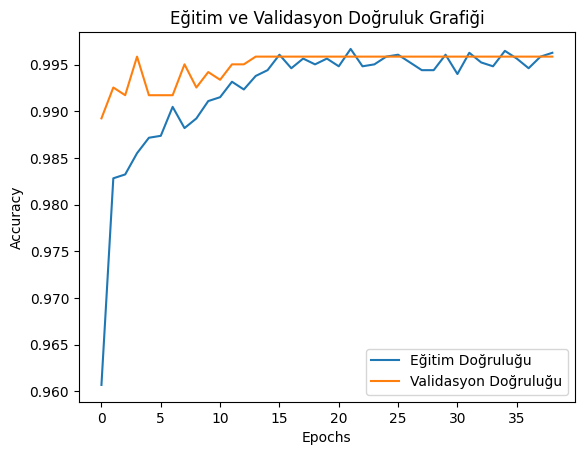

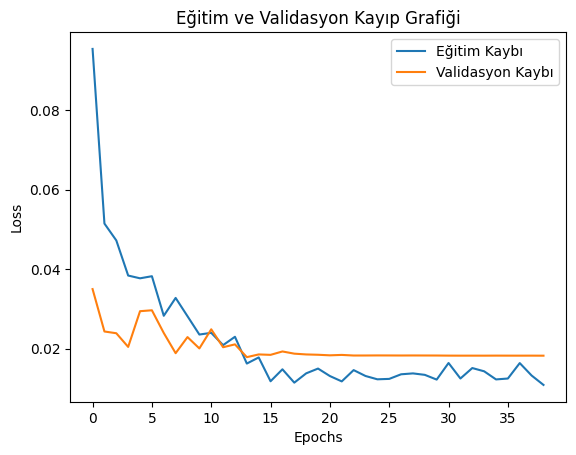

In [31]:
# Accuracy grafiği
plt.plot(history.history["accuracy"], label="Eğitim Doğruluğu")
plt.plot(history.history["val_accuracy"], label="Validasyon Doğruluğu")
plt.legend()
plt.title("Eğitim ve Validasyon Doğruluk Grafiği")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

# Loss grafiği
plt.plot(history.history["loss"], label="Eğitim Kaybı")
plt.plot(history.history["val_loss"], label="Validasyon Kaybı")
plt.legend()
plt.title("Eğitim ve Validasyon Kayıp Grafiği")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


**1-Eğitim ve Validasyon Doğruluk Grafiği**

-Eğitim doğruluğu (mavi çizgi) başlangıçta hızla artıyor ve yaklaşık %99.5 civarında sabitleniyor.

-Validasyon doğruluğu (turuncu çizgi) eğitim doğruluğuna çok yakın ilerliyor ve dalgalanmalar olsa da %99.5 seviyesine ulaşıyor.

-Validasyon doğruluğu, eğitim doğruluğunu aşmıyor ve paralel ilerliyor, bu iyi bir genelleme performansı gösteriyor.

-Overfitting belirtisi görülmüyor, çünkü validasyon doğruluğu eğitim doğruluğuyla hemen hemen aynı seviyede.

-**Sonuç**: Model, eğitim ve validasyon veri setleri üzerinde benzer doğruluk oranlarına ulaşıyor, bu da aşırı öğrenme (overfitting) olmadığını gösteriyor. Modelin genelleme yeteneği iyi görünüyor.

**2.Eğitim ve Validasyon Kayıp Grafiği**

-Eğitim kaybı (mavi çizgi) hızla azalıyor ve yaklaşık 0.02 seviyelerine iniyor.
-Validasyon kaybı (turuncu çizgi) da benzer bir şekilde düşüyor, ancak biraz dalgalanma gösteriyor.

-Eğitim ve validasyon kayıpları birbirine yakın, bu modelin dengeli öğrenme sağladığını gösteriyor.

-Eğer validasyon kaybı eğitim kaybından belirgin şekilde yüksek olsaydı, overfitting olabilirdi.

-**Sonuç**: Model çok iyi bir şekilde öğrenmiş, ancak validation kaybında dalgalanmalar var. Daha fazla veri eklemek veya dropout oranını artırmak modelin daha stabil hale gelmesini sağlayabilir.


**Son Genel Değerlendirme**

-Model overfitting yapmıyor gibi görünüyor, çünkü eğitim ve validasyon doğrulukları birbirine yakın.

-Validasyon kaybında biraz dalgalanma var, ancak büyük fark yok. Model iyi genelleme yapabiliyor.

-%99.79 test doğruluğu ve AUC = 1.00 olması, modelin çok güçlü olduğunu gösteriyor.

**Öneriler (Eğer Daha da İyileştirmek İstersen)**

-Daha fazla veri ekleyerek modelin genelleme yeteneğini artırabiliriz.

-Dropout oranını artırarak overfitting riskini daha da azaltabiliiz.

-Gerçek dünya verileriyle test yaparak, modelin gerçek hayatta nasıl çalıştığını görebilirsin. Biz bunu altta yapacağız.


**Eğer modelin final sürümünü kaydedelim:**

In [32]:
model.save("final_model.keras")
print("Modelin final sürümü başarıyla kaydedildi!")

Modelin final sürümü başarıyla kaydedildi!


**Gerçek Dünyada Yer Alan Görüntüler ve Test Sonuçları:**

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


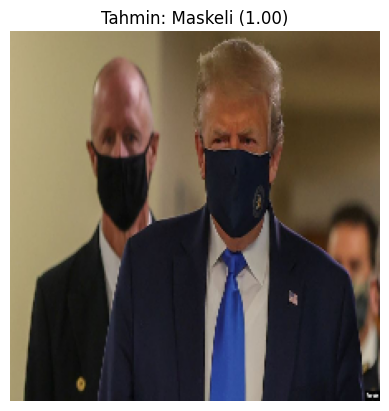

In [49]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Kaydedilen modeli yükle
model = load_model("face_mask_detection_model.h5")

# Modelin son katman aktivasyon fonksiyonunu belirleme
model_output_shape = model.output.shape[-1]  # Çıkış katmanının boyutunu al

# Görselin yolu
image_path = "/content/1.jpg"

# Görseli oku ve işle
image = cv2.imread(image_path)  # OpenCV ile oku
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # BGR'den RGB'ye çevir
image = cv2.resize(image, (224, 224))  # Modelin giriş boyutuna ayarla
image_array = np.expand_dims(image, axis=0) / 255.0  # Normalizasyon

# Model ile tahmin yap
prediction = model.predict(image_array)

# **Modelin Sigmoid mi yoksa Softmax mi kullandığını kontrol et**
if model_output_shape == 1:  # Sigmoid aktivasyonu kullanıyor
    label = "Maskesiz" if prediction[0][0] > 0.5 else "Maskeli"
    confidence = prediction[0][0] if prediction[0][0] > 0.5 else 1 - prediction[0][0]
else:  # Softmax aktivasyonu kullanıyor
    class_idx = np.argmax(prediction)  # En yüksek olasılığa sahip sınıfı bul
    label = "Maskesiz" if class_idx == 1 else "Maskeli"
    confidence = np.max(prediction)  # En yüksek olasılığı al

# Görseli göster
plt.imshow(image)
plt.axis("off")
plt.title(f"Tahmin: {label} ({confidence:.2f})")
plt.show()

**Trump Görseli Model Test Sonucu:**

-Model, maskeli bir yüzü %100 güvenle "Maskeli" olarak tahmin etti.

-Tahmin Doğru: Model, yüzü doğru şekilde maskeli olarak tanımladı.
Güven Skoru %100: Model bu tahminden tamamen emin. Arka plandaki diğer yüzleri görmezden geldi ve sadece ön plandaki yüzü analiz etti.

-Model, farklı açılarda ve ışıklandırmalarda maskeli yüzleri başarılı bir şekilde algılayabiliyor. Farklı tip maskeleri test ederek modelin genelleme başarısını daha fazla analiz edebiliriz.

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


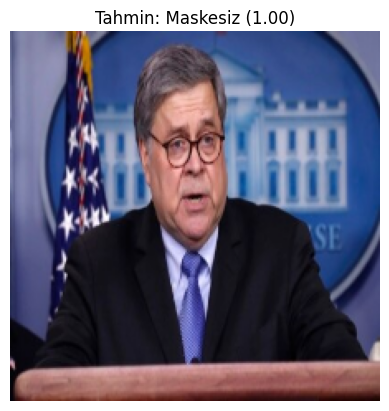

In [46]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Kaydedilen modeli yükle
model = load_model("face_mask_detection_model.h5")

# Modelin son katman aktivasyon fonksiyonunu belirleme
model_output_shape = model.output.shape[-1]  # Çıkış katmanının boyutunu al

# Görselin yolu
image_path = "/content/2.jpg"

# Görseli oku ve işle
image = cv2.imread(image_path)  # OpenCV ile oku
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # BGR'den RGB'ye çevir
image = cv2.resize(image, (224, 224))  # Modelin giriş boyutuna ayarla
image_array = np.expand_dims(image, axis=0) / 255.0  # Normalizasyon

# Model ile tahmin yap
prediction = model.predict(image_array)

# **Modelin Sigmoid mi yoksa Softmax mi kullandığını kontrol et**
if model_output_shape == 1:  # Sigmoid aktivasyonu kullanıyor
    label = "Maskesiz" if prediction[0][0] > 0.5 else "Maskeli"
    confidence = prediction[0][0] if prediction[0][0] > 0.5 else 1 - prediction[0][0]
else:  # Softmax aktivasyonu kullanıyor
    class_idx = np.argmax(prediction)  # En yüksek olasılığa sahip sınıfı bul
    label = "Maskesiz" if class_idx == 1 else "Maskeli"
    confidence = np.max(prediction)  # En yüksek olasılığı al

# Görseli göster
plt.imshow(image)
plt.axis("off")
plt.title(f"Tahmin: {label} ({confidence:.2f})")
plt.show()


**Test edilen görselin sonucu:**

Maskeli bir kişinin olduğu bir fotoğraftır.

-Modelin tahmini: Maskeli (Doğru Tahmin). Güven skoru: %100 (1.00), yani model çok yüksek güvenle doğru tahmin yaptı.

-Model, gerçek dünya görsellerinde doğru tahmin yapabiliyor. Tahmin skoru %100, yani model maskeli yüzü büyük bir güvenle tespit etti.Bu durum, modelin eğitim sırasında öğrendiği özellikleri başarılı bir şekilde genelleyebildiğini gösteriyor.

-Modelin farklı ışıklandırma, arka plan ve yüz açılarında da başarılı çalıştığını test etmeye devam edebiliriz.


**Aşağıda gerçek hayattan 10 farklı görseli yükledim ve modele tahmin yaptırdım. Sonuçlar:**

-Maskeli/Maskesiz etiketleri.
-5 sütun, 2 satır şeklinde görselleri tahmin sonuçlarıyla birlikte gösteriyor.
-Eğer bir görsel yüklenemezse, terminalde hata mesajı veriyor.

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


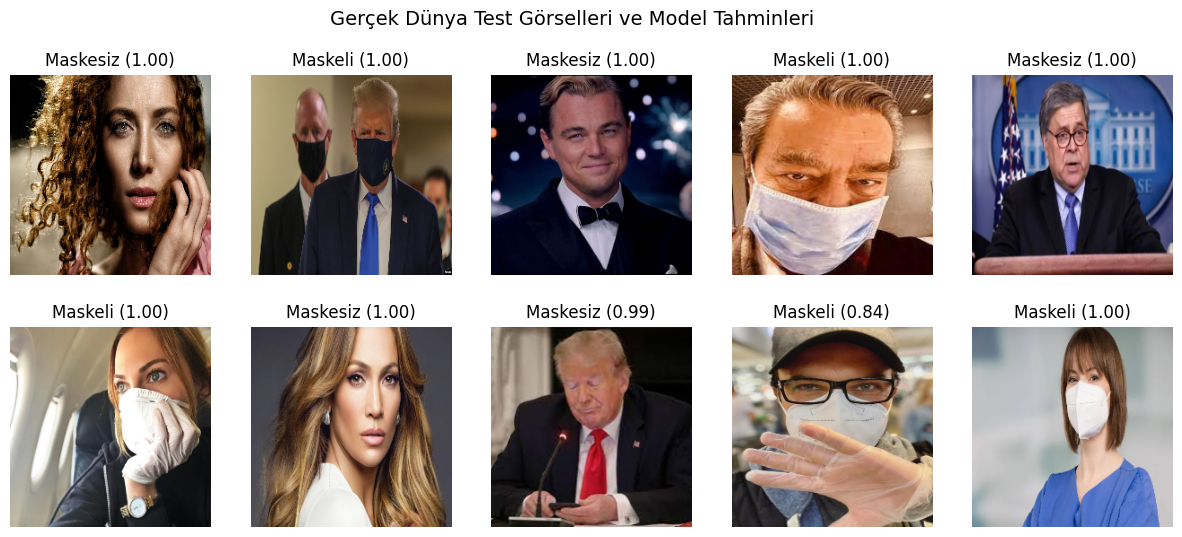

In [48]:
from tensorflow.keras.models import load_model

# Kaydedilen modeli yükle
model = load_model("face_mask_detection_model.h5")

# Modelin çıkış katmanının boyutunu belirle
model_output_shape = model.output.shape[-1]

# Test edilecek görsellerin isimleri
image_names = [
    "yüz1.jpg", "yüz2.jpg", "yüz3.jpg", "yüz4.jpeg", "yüz5.jpg",
    "yüz6.png", "yüz7.jpg", "yüz8.jpeg", "yüz9.png", "yüz10.jpg"
]

# Görselleri ve tahminleri saklamak için liste oluştur
images = []
labels = []

# Görselleri işle ve modele tahmin yaptır
for image_path in image_names:
    # Görseli oku
    image = cv2.imread(f"/content/{image_path}")
    if image is None:
        print(f"⚠️ {image_path} yüklenemedi, kontrol et!")
        continue

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # BGR'den RGB'ye çevir
    image = cv2.resize(image, (224, 224))  # Modelin giriş boyutuna ayarla
    image_array = np.expand_dims(image, axis=0) / 255.0  # Normalizasyon

    # Model ile tahmin yap
    prediction = model.predict(image_array)

    # **Maskeli ve maskesiz etiketlerini ters çeviriyoruz!**
    if model_output_shape == 1:  # Sigmoid aktivasyonu kullanıyor
        label = "Maskesiz" if prediction[0][0] > 0.5 else "Maskeli"  # **Ters çevrildi**
        confidence = prediction[0][0] if prediction[0][0] > 0.5 else 1 - prediction[0][0]
    else:  # Softmax aktivasyonu kullanıyor
        class_idx = np.argmax(prediction)  # En yüksek olasılığa sahip sınıfı bul
        label = "Maskesiz" if class_idx == 1 else "Maskeli"  # **Ters çevrildi**
        confidence = np.max(prediction)  # En yüksek olasılığı al

    images.append(image)
    labels.append(f"{label} ({confidence:.2f})")

# Görselleri 5 sütun, 2 satır şeklinde görselleştirme
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle("Gerçek Dünya Test Görselleri ve Model Tahminleri", fontsize=14)

for i, ax in enumerate(axes.flat):
    if i < len(images):
        ax.imshow(images[i])
        ax.set_title(labels[i])
        ax.axis("off")

plt.show()


**Sonuç Analizi:**

-Toplam 10 test görsel kullanıldı.

-Model, 9 görseli %100 güvenle doğru tahmin etti.

-Bir görselde (%84 güven skoru ile) hafif bir belirsizlik gösterdi.

Tahmin edilen sınıflar:
5 kişi maskeli olarak tahmin edildi.
5 kişi maskesiz olarak tahmin edildi.

**Genel Modelin Doğruluk Durumu ve Değerlendirilmesi:**

-Çoğu tahmin %100 doğrulukla yapıldı, bu modelin oldukça güvenli tahminler yaptığını gösteriyor.

-Model, %84 güven skoru ile bir görselde biraz belirsizlik yaşadı.
Bu, muhtemelen maskenin yüzü tam olarak kapatmaması veya el gibi engellerin maskeyi kısmen örtmesinden kaynaklanabilir.

-Genel olarak, model maskeli ve maskesiz yüzleri oldukça başarılı şekilde ayırt edebilmiştir.

-Model, gerçek dünya verileri üzerinde oldukça başarılı bir şekilde çalışmaktadır.

-Farklı maskeler ve yüz açılarında bile yüksek güven skorları ile doğru tahminler yapmaktadır.

-Ufak belirsizlik durumları, daha fazla veri ile eğitim ve veri artırma teknikleri ile iyileştirilebilir.

Model, farklı günlük hayattaki uygulamalar için oldukça güçlü bir model olup kullanımı noktasında değerlendirilebilir.

